# Language-Recognition using ConvNets

_written by Joscha S. Rieber (Fraunhofer IAIS) in 2020_

## Training Environment

In [ ]:
train = 'train'
test = 'test'

eng = 'english'
ger = 'german'

languages = [eng, ger]
categories = [train, test]

dataset_root_path = '../data/'
train_path = dataset_root_path + train

batch_size = 128
image_width = 500
image_height = 128

validation_split = 0.1
initial_learning_rate = 0.045

num_classes = len(languages)

model_file = dataset_root_path + 'model.h5'

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# XLA compiles your TensorFlow graph into a sequence of GPU kernels generated specifically for your model.
# Since these kernels are unique to your program, they can exploit model-specific information for optimization.

# import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_cpu_global_jit'

In [ ]:
all_files = glob(train_path + '/*/*.png')

num_validation = len(all_files) * validation_split
num_train = len(all_files) - num_validation

validation_steps = int(num_validation / batch_size)
steps_per_epoch = int(num_train / batch_size)

print('Steps per Epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

## Training Batch Generator Function

The following function loads the available images for training, shuffles them and serves them to Keras' training algorithm.

In [4]:
image_data_generator = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
train_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='training')
validation_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='validation')

Found 57600 images belonging to 2 classes.
Found 6400 images belonging to 2 classes.


## Model definition

In [5]:
import math

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Input, Concatenate, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, RMSprop

In [6]:
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.applications.inception_v3 import InceptionV3

img_input = Input(shape=(image_height, image_width, 1))

img_conc = Concatenate(axis=3, name='input_concat')([img_input, img_input, img_input])

model = InceptionV3(input_tensor=img_conc, weights=None, include_top=True, classes=2)

model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 500, 1) 0                                            
__________________________________________________________________________________________________
input_concat (Concatenate)      (None, 128, 500, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 249, 32)  864         input_concat[0][0]               
_______________________________________________________________________________________

In [7]:
#model = Sequential()

#model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(image_height, image_width, 1)))
#model.add(MaxPooling2D())
#model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D())
#model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D())
#model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D())
#model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D())
#model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(num_classes, activation='softmax'))

#model.summary()

In [8]:
model.compile(optimizer=RMSprop(lr=initial_learning_rate, clipvalue=2.0), loss='categorical_crossentropy', metrics=['accuracy'])

## Training

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [16]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

In [17]:
def step_decay(epoch, lr):
    drop = 0.94
    epochs_drop = 2.0
    lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

learning_rate_decay = LearningRateScheduler(step_decay, verbose=1)

In [18]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=60, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[early_stopping, learning_rate_decay])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.04500000178813934.
Epoch 1/60
450/450 [==============================] - 438s 973ms/step - loss: 1.0226 - accuracy: 0.5636 - val_loss: 103.4159 - val_accuracy: 0.4922 - lr: 0.0450

Epoch 00002: LearningRateScheduler reducing learning rate to 0.042300001680850983.
Epoch 2/60
450/450 [==============================] - 436s 970ms/step - loss: 0.6147 - accuracy: 0.6424 - val_loss: 1.0652 - val_accuracy: 0.5813 - lr: 0.0423

Epoch 00003: LearningRateScheduler reducing learning rate to 0.03976200073957443.
Epoch 3/60
450/450 [==============================] - 436s 969ms/step - loss: 0.3428 - accuracy: 0.8524 - val_loss: 0.9368 - val_accuracy: 0.6242 - lr: 0.0398

Epoch 00004: LearningRateScheduler reducing learning rate to 0.03513370451182127.
Epoch 4/60
450/450 [==============================] - 435s 967ms/step - loss: 0.2493 - accuracy: 0.8971 - val_loss: 0.5853 - val_accuracy: 0.8019 - lr: 0.0351

Epoch 00005: LearningRateSch

In [19]:
model.save(model_file)

In [21]:
import matplotlib.pyplot as plt

## Plot Training History for Accuracy

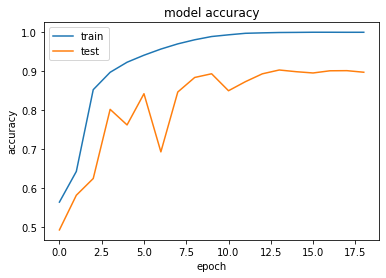

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model Evaluation Environment


The following function loads the available images for evaluation

In [30]:
test_path = dataset_root_path + test

In [31]:
all_files = glob(test_path + '/*/*.png')

num_test = len(all_files)

evaluation_steps = int(num_test / batch_size)

print('Evaluation steps: ' + str(evaluation_steps))

Evaluation steps: 62


In [32]:
image_data_generator = ImageDataGenerator(rescale=1./255)
evaluation_generator = image_data_generator.flow_from_directory(test_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale')

Found 8000 images belonging to 2 classes.


## Model Evaluation

In [33]:
from tensorflow.keras.models import load_model

In [34]:
model = load_model(model_file)

In [35]:
_, test_accuracy = model.evaluate(evaluation_generator, steps=evaluation_steps)

62/62 [==============================] - 15s 245ms/step - loss: 0.4755 - accuracy: 0.9304


In [36]:
print('Test accuracy: ' + str(round(test_accuracy * 100., 1)) + ' %')

Test accuracy: 93.0 %
